# Read KNMI observations using hydropandas

This notebook introduces how to use the `hydropandas` package to read, process and visualise KNMI data.

## <a id=top></a>Notebook contents

1. [KnmiObs](#KnmiObs)
2. [Get KNMI data](#reading)
3. [Get ObsCollections](#readingOC)

In [1]:
from hydropandas import ObsCollection
from hydropandas.io import io_knmi
from hydropandas.observation import KnmiObs
from IPython.display import display

import pandas as pd
import numpy as np

import logging

In [2]:
logging.basicConfig(level=logging.INFO)

## KnmiObs<a id=KNMIObs></a>

The hydropandas package has a function to read all kinds of KNMI observation. These are stored in a `KnmiObs` object. With the code below we get the Evaporation in [m/day] for KNMI station 344 (Rotterdam Airport).

In [3]:
o = KnmiObs.from_knmi(344, 'EV24')
o.head()

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2019-12-30 00:00:00 and 2021-08-15 11:46:10.346683
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


,metadata
name,ROTTERDAM
x,90598.0
y,442813.0
filename,
station,344
meteo_var,EV24
,EV24
2019-12-31 01:00:00,0.0005
2020-01-01 01:00:00,0.0004
2020-01-02 01:00:00,0.0001


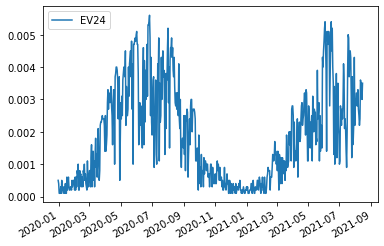

In [4]:
o.plot();

**attributes**

A `KnmiObs` object has the following attributes:

* `name`: station name and variable
* `x`: x-coördinate in m RD
* `y`: y-coördinate in m RD
* `station`: station number
* `meta`: dictionary with other metadata

In [5]:
print(f"name: {o.name}")
print(f"x,y: {(o.x, o.y)}")
print(f"station: {o.station}")
print("metadata:")
for key, item in o.meta.items():
    print(f'    {key}: {item}')

name: ROTTERDAM
x,y: (90598.0, 442813.0)
station: 344
metadata:
    LON_east: {'344': 4.447}
    LAT_north: {'344': 51.962}
    ALT_m: {'344': -4.3}
    NAME: {'344': 'Rotterdam'}
    EV24: Referentiegewasverdamping (Makkink) (in m) / Potential evapotranspiration (Makkink) (in m)
    x: 90598.0
    y: 442813.0
    station: 344
    name: ROTTERDAM


## Get KNMI data<a id=reading></a>

There are 2 main functions to obtain KNMI data:

1. `KnmiObs.from_knmi`
2. `KnmiObs.from_nearest_xy`

Below you can see how they can be called. Notice that they return the same data because station 344 is nearest to the given xy coördinates.

In [6]:
o1 = KnmiObs.from_knmi(344, 'EV24')
o2 = KnmiObs.from_nearest_xy(90600, 442800, 'EV24')
o1.equals(o2)

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2019-12-30 00:00:00 and 2021-08-15 11:46:12.695806
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2019-12-30 00:00:00 and 2021-08-15 11:46:12.896029
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements


True

**read options**

The `KnmiObs.from_knmi` method contains the following keyword arguments:

- `stn`: station number.
- `variable`: the type of measurement you want to get. For a list of all variable names check: http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi
- `startdate`: the start date of the time series you want, default is 1st of January 2019.
- `enddate`: the end date of the time series you want, default is today.
- `fill_missing_obs`: option to fill missing values with values from the nearest KNMI station. If measurements are filled an extra column is added to the time series in which the station number is shown that was used to fill a particular missing value.
- `interval`: time interval of the time series, default is 'daily'
- `raise_exception`: option to raise an error when the requested time series is empty.
***

The 3 examples below give a brief summary of these options

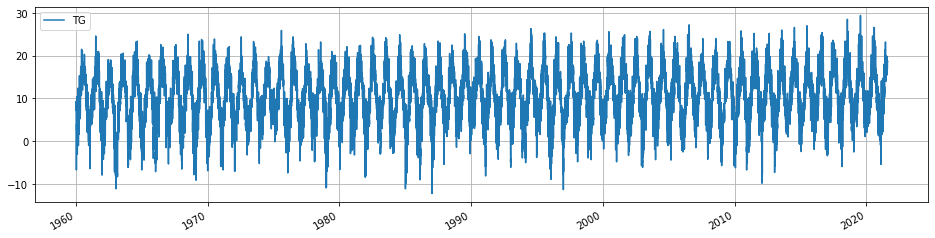

In [7]:
#example 1 get daily average temperature from 1900 till now
o_t = KnmiObs.from_knmi(344, 'TG', startdate='1960')
o_t.plot(figsize=(16,4), grid=True);

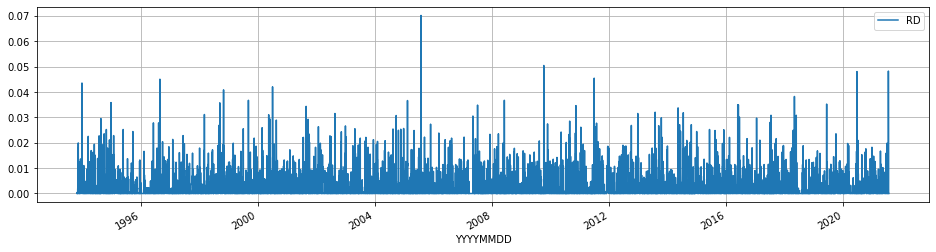

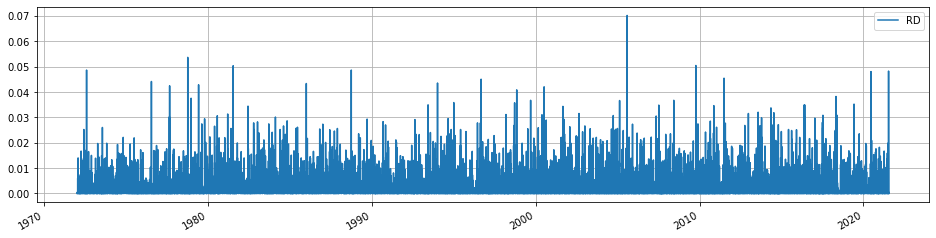

In [8]:
#example 2 get daily average precipitation from 1972 with and without filling missing measurements
o_rd = KnmiObs.from_knmi(892, 'RD', startdate='1972', fill_missing_obs=False)
o_rd.plot(figsize=(16,4), grid=True)

o_rd_filled = KnmiObs.from_knmi(892, 'RD', startdate='1972', fill_missing_obs=True)
o_rd_filled.plot(figsize=(16,4), grid=True);

In [9]:
#see the station_opvulwaarde
display(o_rd.head())
display(o_rd_filled.head())

,metadata
name,GIERSBERGEN
x,138555.684384
y,406719.896061
filename,
station,892
meteo_var,RD
,RD
YYYYMMDD,
1993-11-01 09:00:00,0.0000
1993-11-02 09:00:00,0.0000


-----metadata------
name : GIERSBERGEN 
x : 138555.6843835866 
y : 406719.8960605697 
meta : {'RD': '24-uur som van de neerslag in m van 08.00 voorafgaande dag- 08.00 UTC huidige dag', 'x': 138555.6843835866, 'y': 406719.8960605697, 'station': 892, 'name': 'GIERSBERGEN'} 
filename :  
station : 892 
meteo_var : RD 

                      RD station_opvulwaarde
1971-12-31 09:00:00  0.0                 910
1972-01-01 09:00:00  0.0                 910
1972-01-02 09:00:00  0.0                 910
1972-01-03 09:00:00  0.0                 910
1972-01-04 09:00:00  0.0                 910

In [10]:
# example 3 get evaporation and print additional information during download using the logging module
logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.INFO)

o_ev = KnmiObs.from_knmi(344, 'EV24', startdate='1972', fill_missing_obs=True)
o_ev

INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 1971-12-30 00:00:00 and 2021-08-15 11:34:06.059254
INFO:hydropandas.io.io_knmi:station 344 has no measurements before 1987-09-12 01:00:00
INFO:hydropandas.io.io_knmi:station 344 has 5810 missing measurements
INFO:hydropandas.io.io_knmi:trying to fill 5810 measurements with station [210]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 210-VALKENBURG between 1971-12-30 00:00:00 and 2021-08-15 11:34:06.059254
INFO:hydropandas.io.io_knmi:trying to fill 5564 measurements with station [330]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 330-HOEK-VAN-HOLLAND between 1971-12-30 00:00:00 and 2021-08-15 11:34:06.059254
INFO:hydropandas.io.io_knmi:trying to fill 5564 measurements with station [348]
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 348-CABAUW between 1971-12-30 00:00:00 and 2021-08-15 11:34:06.059254
INFO:hydropandas.io.io_knmi:trying to fill 550

-----metadata------
name : ROTTERDAM 
x : 90598.0 
y : 442813.0 
meta : {'LON_east': {'344': 4.447}, 'LAT_north': {'344': 51.962}, 'ALT_m': {'344': -4.3}, 'NAME': {'344': 'Rotterdam'}, 'EV24': 'Referentiegewasverdamping (Makkink) (in m) / Potential evapotranspiration (Makkink) (in m)', 'x': 90598.0, 'y': 442813.0, 'station': 344, 'name': 'ROTTERDAM'} 
filename :  
station : 344 
meteo_var : EV24 

                       EV24 station_opvulwaarde
1971-12-31 01:00:00  0.0001                 260
1972-01-01 01:00:00  0.0002                 260
1972-01-02 01:00:00  0.0002                 260
1972-01-03 01:00:00  0.0002                 260
1972-01-04 01:00:00  0.0000                 260
...                     ...                 ...
2021-08-11 01:00:00  0.0036                 NaN
2021-08-12 01:00:00  0.0035                 NaN
2021-08-13 01:00:00  0.0035                 NaN
2021-08-14 01:00:00  0.0030                 NaN
2021-08-15 01:00:00  0.0035                 NaN

[18126 rows x 2 columns]

## Get ObsCollections<a id=readingOC></a>

It is also possible to read multiple `KnmiObs` objects at once and store them in an `ObsCollection` object. For this we use the `ObsCollection.from_knmi()` method. Below an example to obtain precipitation (RH) and evaporation (EV24) from the KNMI station of Rotterdam and De Bilt. 

In [11]:
oc = ObsCollection.from_knmi(stns=[344, 260], meteo_vars=['RH', 'EV24'])
oc

INFO:hydropandas.io.io_knmi:download knmi RH data from station 344-ROTTERDAM between 2019-12-29 00:00:00 and 2021-08-15 11:34:09.602931
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi RH data from station 260-DE-BILT between 2019-12-29 00:00:00 and 2021-08-15 11:34:09.602931
INFO:hydropandas.io.io_knmi:station 260 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 344-ROTTERDAM between 2019-12-29 00:00:00 and 2021-08-15 11:34:10.025671
INFO:hydropandas.io.io_knmi:station 344 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 260-DE-BILT between 2019-12-29 00:00:00 and 2021-08-15 11:34:10.025671
INFO:hydropandas.io.io_knmi:station 260 has 0 missing measurements


,x,y,filename,station,meteo_var,obs
name,,,,,,
ROTTERDAM,90598.000000,442813.000000,,344,RH,-----metadata------ name : ROTTERDAM x : 9059...
DE-BILT,141002.996557,456772.017696,,260,RH,-----metadata------ name : DE-BILT x : 141002...
ROTTERDAM,90598.000000,442813.000000,,344,EV24,-----metadata------ name : ROTTERDAM x : 9059...
DE-BILT,141002.996557,456772.017696,,260,EV24,-----metadata------ name : DE-BILT x : 141002...


Besides giving a list of stations it is also possible to:
- specify `locations` as a dataframe with x, y coördinates (RD_new), the function will find the nearest KNMI station for every location.
- specify `xmid` and `ymid` which are 2 arrays corresponding to a structured grid to obtain the nearest KNMI station for every cell in the grid.

In [12]:
ObsCollection.from_knmi(locations=pd.DataFrame(index=['Rotterdam'], data ={'x':77500, 'y':399500}), 
                        meteo_vars=['RH'])

INFO:hydropandas.io.io_knmi:download knmi RH data from station 340-WOENSDRECHT between 2019-12-28 00:00:00 and 2021-08-15 11:34:09.602931
INFO:hydropandas.io.io_knmi:station 340 has 0 missing measurements


,x,y,filename,station,meteo_var,obs
name,,,,,,
WOENSDRECHT,82881.403813,384958.510811,,340,RH,-----metadata------ name : WOENSDRECHT x : 82...


In [13]:
ObsCollection.from_knmi(xmid=np.array([77500]), ymid=np.array([399500]), 
                        meteo_vars=['RH'])

INFO:hydropandas.io.io_knmi:download knmi RH data from station 340-WOENSDRECHT between 2019-12-27 00:00:00 and 2021-08-15 11:34:09.602931
INFO:hydropandas.io.io_knmi:station 340 has 0 missing measurements


,x,y,filename,station,meteo_var,obs
name,,,,,,
WOENSDRECHT,82881.403813,384958.510811,,340,RH,-----metadata------ name : WOENSDRECHT x : 82...
